In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import streamlit as st

In [27]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [28]:
# Set the style for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [29]:
# Define color palettes
color_palette = sns.color_palette("viridis", 10)
categorical_palette = sns.color_palette("Set2", 8)

In [30]:
# a) Import data & info()
print("Importing data...")
df = pd.read_parquet('green_tripdata_2020-12.parquet')
print("Data Information:")
df.info()
print("\nSample Data:")
print(df.head())

Importing data...
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83130 entries, 0 to 83129
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               83130 non-null  int64         
 1   lpep_pickup_datetime   83130 non-null  datetime64[us]
 2   lpep_dropoff_datetime  83130 non-null  datetime64[us]
 3   store_and_fwd_flag     46292 non-null  object        
 4   RatecodeID             46292 non-null  float64       
 5   PULocationID           83130 non-null  int64         
 6   DOLocationID           83130 non-null  int64         
 7   passenger_count        46292 non-null  float64       
 8   trip_distance          83130 non-null  float64       
 9   fare_amount            83130 non-null  float64       
 10  extra                  83130 non-null  float64       
 11  mta_tax                83130 non-null  float64       
 12  tip_amount             8

In [31]:
# b) Drop ehail_fee column
if 'ehail_fee' in df.columns:
    df = df.drop('ehail_fee', axis=1)
    print("\nEhail_fee column dropped")
else:
    print("\nEhail_fee column does not exist in the dataset")


Ehail_fee column dropped


In [32]:
# c) Calculate trip_duration based on pickup & dropoff date variables in minutes
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
print("\nTrip duration calculated in minutes")
print(df['trip_duration'].describe())


Trip duration calculated in minutes
count    83130.000000
mean        21.350007
std         66.581439
min         -0.166667
25%          8.000000
50%         14.000000
75%         23.950000
max       1439.016667
Name: trip_duration, dtype: float64


In [33]:
# d) Extract weekday as new variable "weekday" from dropoff date variable
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
print("\nWeekday value counts:")
print(df['weekday'].value_counts())


Weekday value counts:
weekday
Tuesday      16211
Wednesday    15928
Thursday     12768
Monday       12504
Friday       10833
Saturday      8296
Sunday        6590
Name: count, dtype: int64


In [34]:
# d) Extract weekday as new variable "weekday" from dropoff date variable
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
print("\nWeekday value counts:")
print(df['weekday'].value_counts())


Weekday value counts:
weekday
Tuesday      16211
Wednesday    15928
Thursday     12768
Monday       12504
Friday       10833
Saturday      8296
Sunday        6590
Name: count, dtype: int64


In [35]:
# e) Extract hour as new variable "hourofday" from dropoff date variable
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
print("\nHour of day value counts:")
print(df['hourofday'].value_counts())


Hour of day value counts:
hourofday
13    6697
10    6362
14    6353
15    6282
11    6222
12    6206
9     6087
16    5882
17    5354
8     4742
18    4703
19    3712
7     3034
20    2741
21    1897
22    1510
6     1360
23    1260
0      732
5      708
4      484
1      412
2      217
3      173
Name: count, dtype: int64


In [37]:
# Create payment type mapping
payment_type_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}

# Create trip type mapping
trip_type_mapping = {
    1: 'Street-hail',
    2: 'Dispatch'
}

# Create ratecode mapping
ratecode_mapping = {
    1: 'Standard rate',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated fare',
    6: 'Group ride'
}

# Apply mappings to create readable categories
df['payment_type_desc'] = df['payment_type'].map(payment_type_mapping)
if 'trip_type' in df.columns:
    df['trip_type_desc'] = df['trip_type'].map(trip_type_mapping)
df['ratecode_desc'] = df['RatecodeID'].map(ratecode_mapping)

In [39]:
# f) Missing Values Imputation
print("\nMissing values before imputation:")
print(df.isnull().sum())

# Impute numeric columns with median
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
                'tolls_amount', 'improvement_surcharge', 'total_amount', 
                'congestion_surcharge', 'trip_duration', 'passenger_count']

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
categorical_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Fill NaN values in descriptive columns based on their numeric counterparts
if 'payment_type_desc' in df.columns and df['payment_type_desc'].isnull().any():
    df['payment_type_desc'] = df['payment_type'].map(payment_type_mapping)
if 'trip_type_desc' in df.columns and df['trip_type_desc'].isnull().any():
    df['trip_type_desc'] = df['trip_type'].map(trip_type_mapping)
if 'ratecode_desc' in df.columns and df['ratecode_desc'].isnull().any():
    df['ratecode_desc'] = df['RatecodeID'].map(ratecode_mapping)

print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values before imputation:
VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       36838
RatecodeID               36838
PULocationID                 0
DOLocationID                 0
passenger_count          36838
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
payment_type             36838
trip_type                36838
congestion_surcharge     36838
trip_duration                0
weekday                      0
hourofday                    0
payment_type_desc        36838
trip_type_desc           36838
ratecode_desc            36838
dtype: int64

Missing values after imputation:
VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocati

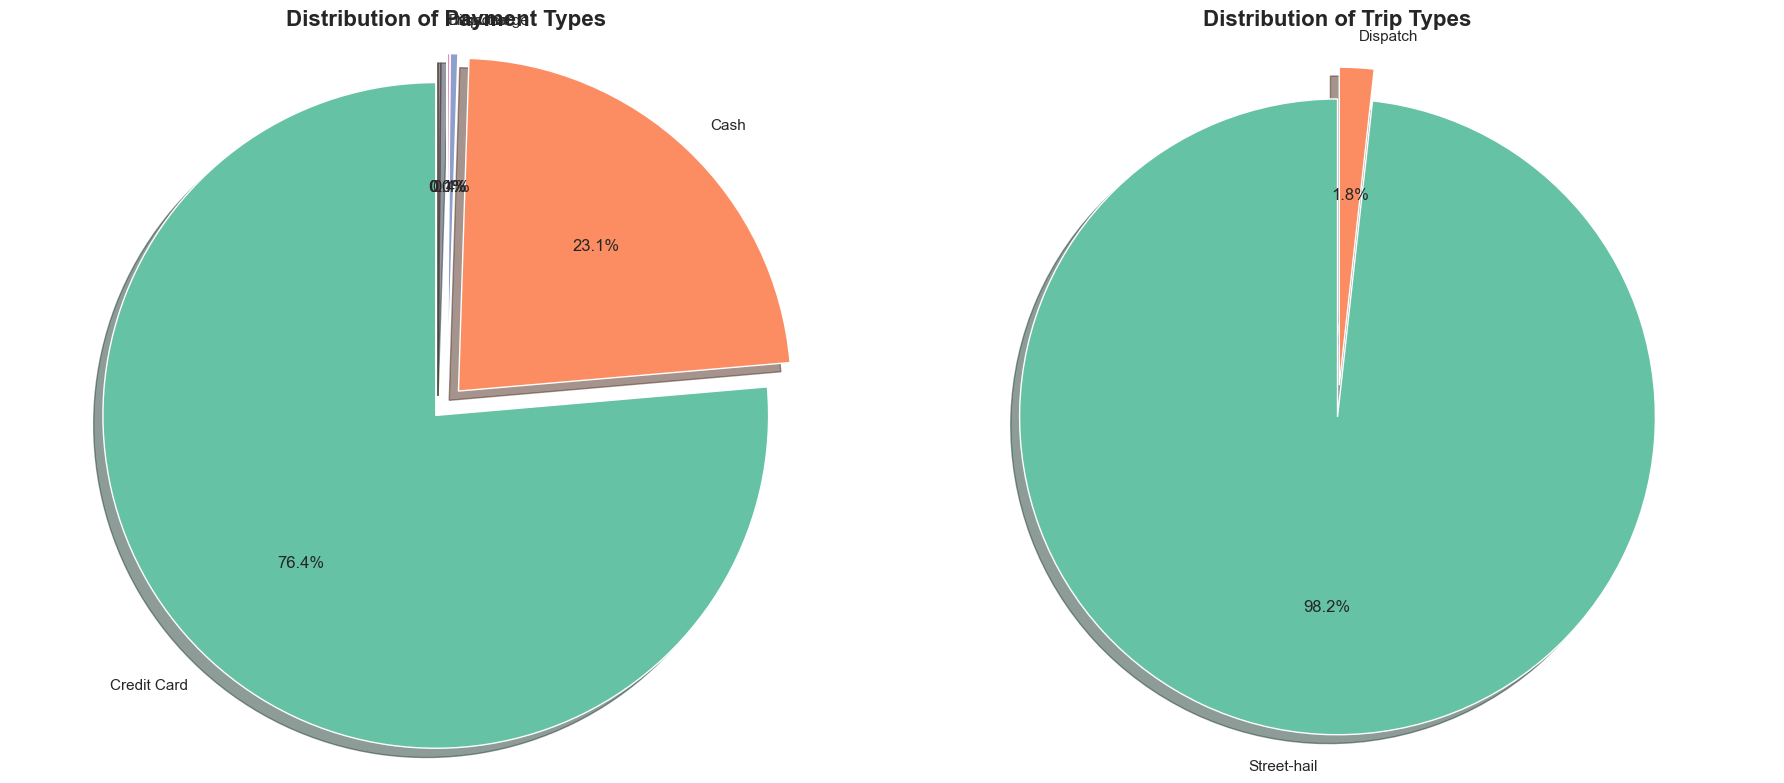

In [44]:
# g) Pie diagram of payment_type, trip_type
plt.figure(figsize=(18, 8))

# Payment Type Pie Chart with descriptive labels
plt.subplot(1, 2, 1)
payment_counts = df['payment_type_desc'].value_counts()
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=categorical_palette, shadow=True, explode=[0.05]*len(payment_counts))
plt.title('Distribution of Payment Types', fontsize=16, fontweight='bold')
plt.axis('equal')

# Trip Type Pie Chart with descriptive labels
plt.subplot(1, 2, 2)
if 'trip_type_desc' in df.columns:
    trip_counts = df['trip_type_desc'].value_counts()
    plt.pie(trip_counts, labels=trip_counts.index, autopct='%1.1f%%', startangle=90, 
            colors=categorical_palette[:len(trip_counts)], shadow=True, explode=[0.05]*len(trip_counts))
    plt.title('Distribution of Trip Types', fontsize=16, fontweight='bold')
    plt.axis('equal')
else:
    plt.text(0.5, 0.5, 'Trip Type column does not exist', ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.savefig('payment_trip_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Average total amount by weekday:
     weekday  total_amount
0     Friday     23.200268
1     Monday     24.008743
2   Saturday     21.811270
3     Sunday     22.521838
4   Thursday     22.889385
5    Tuesday     23.781704
6  Wednesday     23.554299


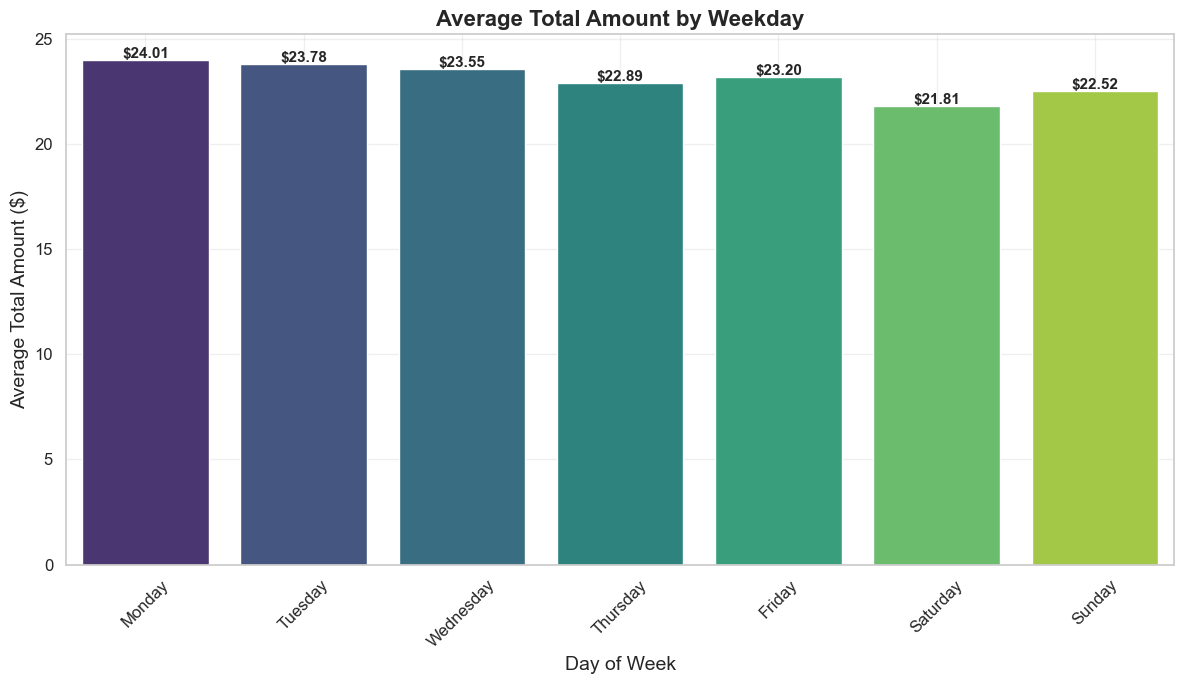

In [45]:
# h) Groupby() of average total_amount & weekday
avg_total_by_weekday = df.groupby('weekday')['total_amount'].mean().reset_index()
print("\nAverage total amount by weekday:")
print(avg_total_by_weekday)

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_total_by_weekday['weekday'] = pd.Categorical(avg_total_by_weekday['weekday'], categories=weekday_order, ordered=True)
avg_total_by_weekday = avg_total_by_weekday.sort_values('weekday')

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='weekday', y='total_amount', data=avg_total_by_weekday, palette=sns.color_palette('viridis', 7))
plt.title('Average Total Amount by Weekday', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Total Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars
for i, v in enumerate(avg_total_by_weekday['total_amount']):
    ax.text(i, v + 0.1, f'${v:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('avg_total_by_weekday.png', dpi=300, bbox_inches='tight')
plt.show()


Average total amount by payment type:
  payment_type_desc  total_amount
0              Cash     12.706091
1       Credit Card     26.598882
2           Dispute      1.885268
3         No Charge      2.355342
4           Unknown     23.800000


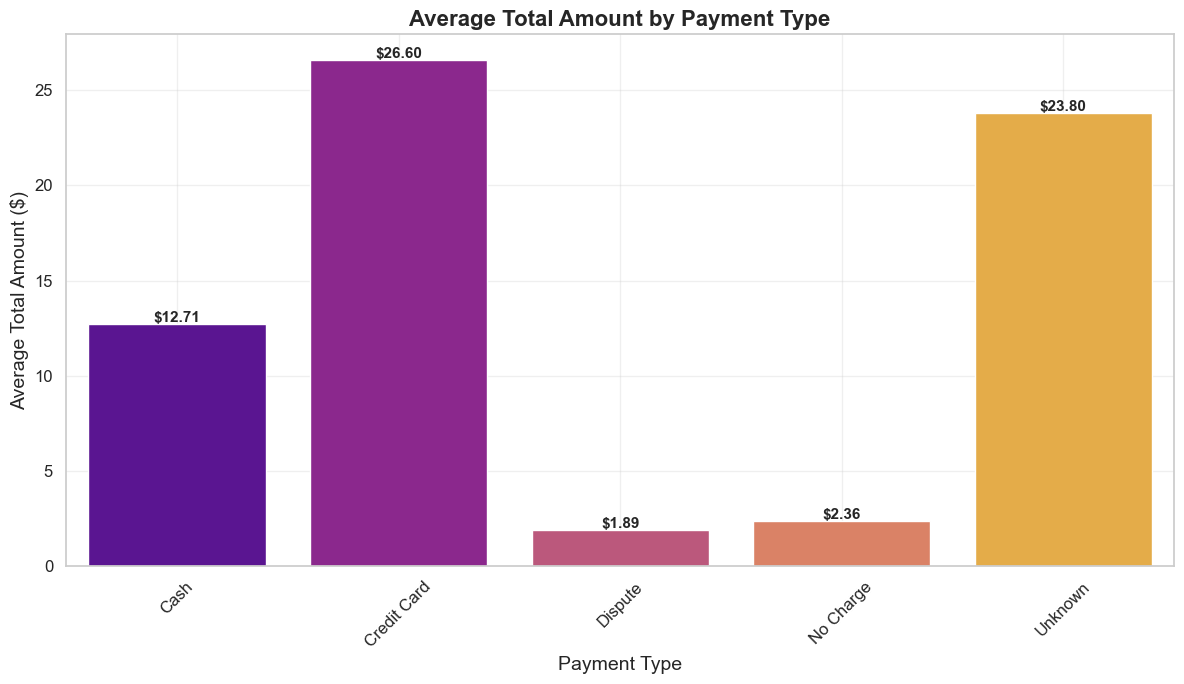

In [46]:
# i) Groupby() of average total_amount & payment_type
avg_total_by_payment = df.groupby('payment_type_desc')['total_amount'].mean().reset_index()
print("\nAverage total amount by payment type:")
print(avg_total_by_payment)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='payment_type_desc', y='total_amount', data=avg_total_by_payment, palette=sns.color_palette('plasma', len(avg_total_by_payment)))
plt.title('Average Total Amount by Payment Type', fontsize=16, fontweight='bold')
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Average Total Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars
for i, v in enumerate(avg_total_by_payment['total_amount']):
    ax.text(i, v + 0.1, f'${v:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('avg_total_by_payment.png', dpi=300, bbox_inches='tight')
plt.show()


Average tip amount by weekday:
     weekday  tip_amount
0     Friday    1.975649
1     Monday    2.098929
2   Saturday    1.813588
3     Sunday    1.876980
4   Thursday    1.963801
5    Tuesday    2.083197
6  Wednesday    2.058929


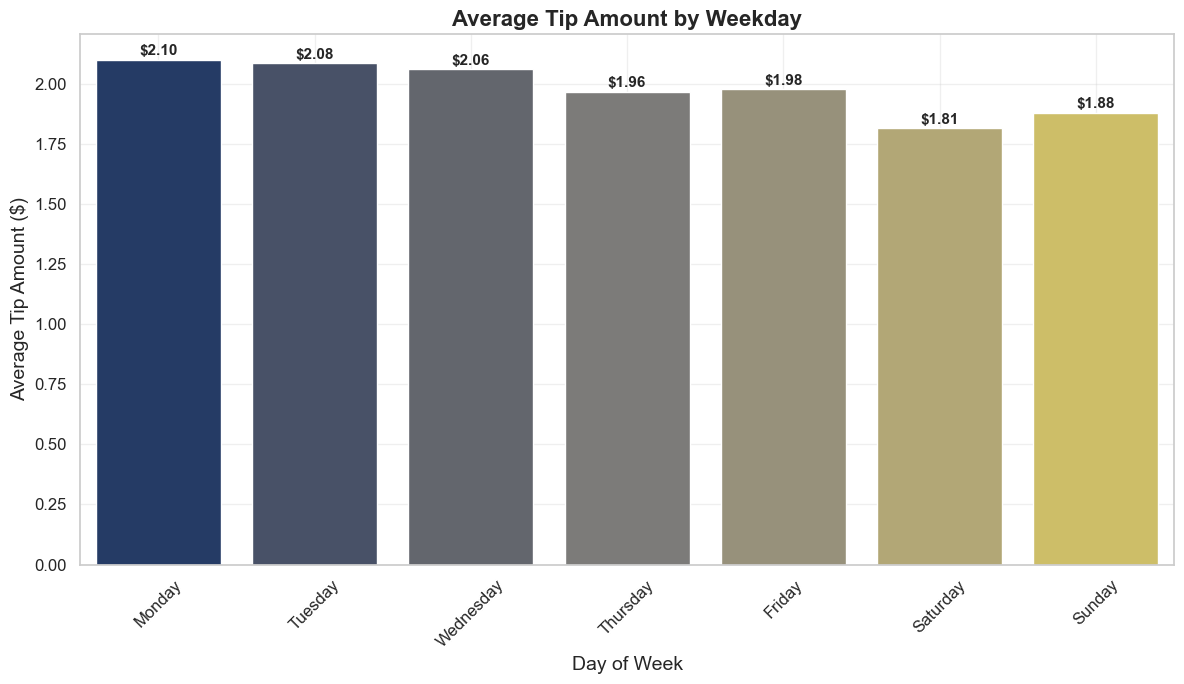

In [47]:
# j) Groupby() of average tip_amount & weekday
avg_tip_by_weekday = df.groupby('weekday')['tip_amount'].mean().reset_index()
print("\nAverage tip amount by weekday:")
print(avg_tip_by_weekday)

# Reorder weekdays
avg_tip_by_weekday['weekday'] = pd.Categorical(avg_tip_by_weekday['weekday'], categories=weekday_order, ordered=True)
avg_tip_by_weekday = avg_tip_by_weekday.sort_values('weekday')

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='weekday', y='tip_amount', data=avg_tip_by_weekday, palette=sns.color_palette('cividis', 7))
plt.title('Average Tip Amount by Weekday', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Tip Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars
for i, v in enumerate(avg_tip_by_weekday['tip_amount']):
    ax.text(i, v + 0.02, f'${v:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('avg_tip_by_weekday.png', dpi=300, bbox_inches='tight')
plt.show()


Average tip amount by payment type:
  payment_type_desc  tip_amount
0              Cash    0.000000
1       Credit Card    2.625934
2           Dispute    0.000000
3         No Charge   -0.011661
4           Unknown    0.000000


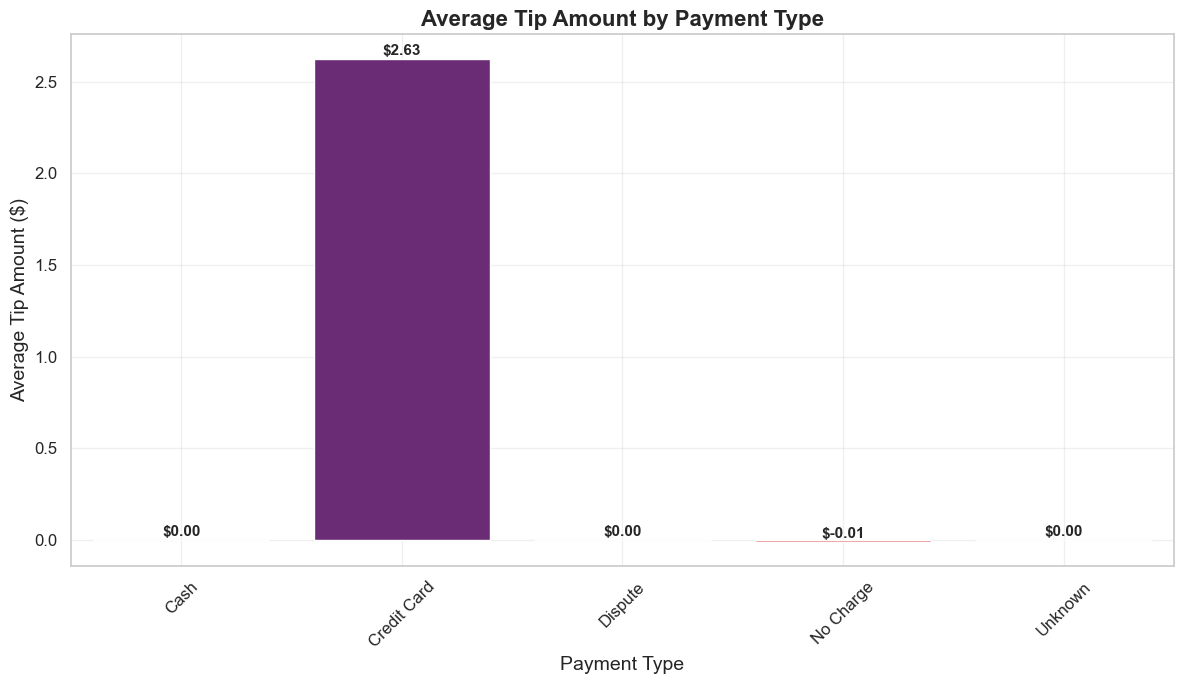

In [48]:
# k) Groupby() of average tip_amount & payment_type
avg_tip_by_payment = df.groupby('payment_type_desc')['tip_amount'].mean().reset_index()
print("\nAverage tip amount by payment type:")
print(avg_tip_by_payment)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='payment_type_desc', y='tip_amount', data=avg_tip_by_payment, palette=sns.color_palette('magma', len(avg_tip_by_payment)))
plt.title('Average Tip Amount by Payment Type', fontsize=16, fontweight='bold')
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Average Tip Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars
for i, v in enumerate(avg_tip_by_payment['tip_amount']):
    ax.text(i, v + 0.02, f'${v:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('avg_tip_by_payment.png', dpi=300, bbox_inches='tight')
plt.show()

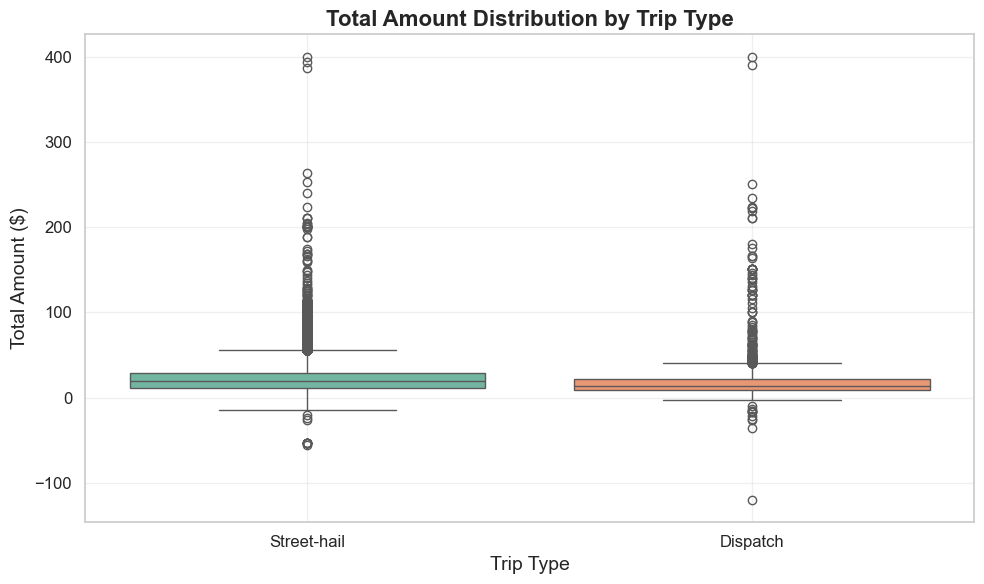


ANOVA Test for Total Amount across Trip Types:
F-statistic: 42.9949
p-value: 0.0000
Reject null hypothesis: Average total amounts are not identical across trip types


In [49]:
# l) Test null average total_amount of different trip_type is identical
if 'trip_type_desc' in df.columns:
    # Create a boxplot to visualize the distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='trip_type_desc', y='total_amount', data=df, palette=sns.color_palette('Set2', 2))
    plt.title('Total Amount Distribution by Trip Type', fontsize=16, fontweight='bold')
    plt.xlabel('Trip Type', fontsize=14)
    plt.ylabel('Total Amount ($)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('total_amount_by_trip_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Performing ANOVA test
    trip_types = df['trip_type'].unique()
    trip_type_groups = [df[df['trip_type'] == trip_type]['total_amount'] for trip_type in trip_types]
    
    f_stat, p_value = stats.f_oneway(*trip_type_groups)
    
    print("\nANOVA Test for Total Amount across Trip Types:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Reject null hypothesis: Average total amounts are not identical across trip types")
    else:
        print("Fail to reject null hypothesis: Average total amounts are identical across trip types")
else:
    print("\nTrip Type column does not exist. Cannot perform ANOVA test for trip types.")

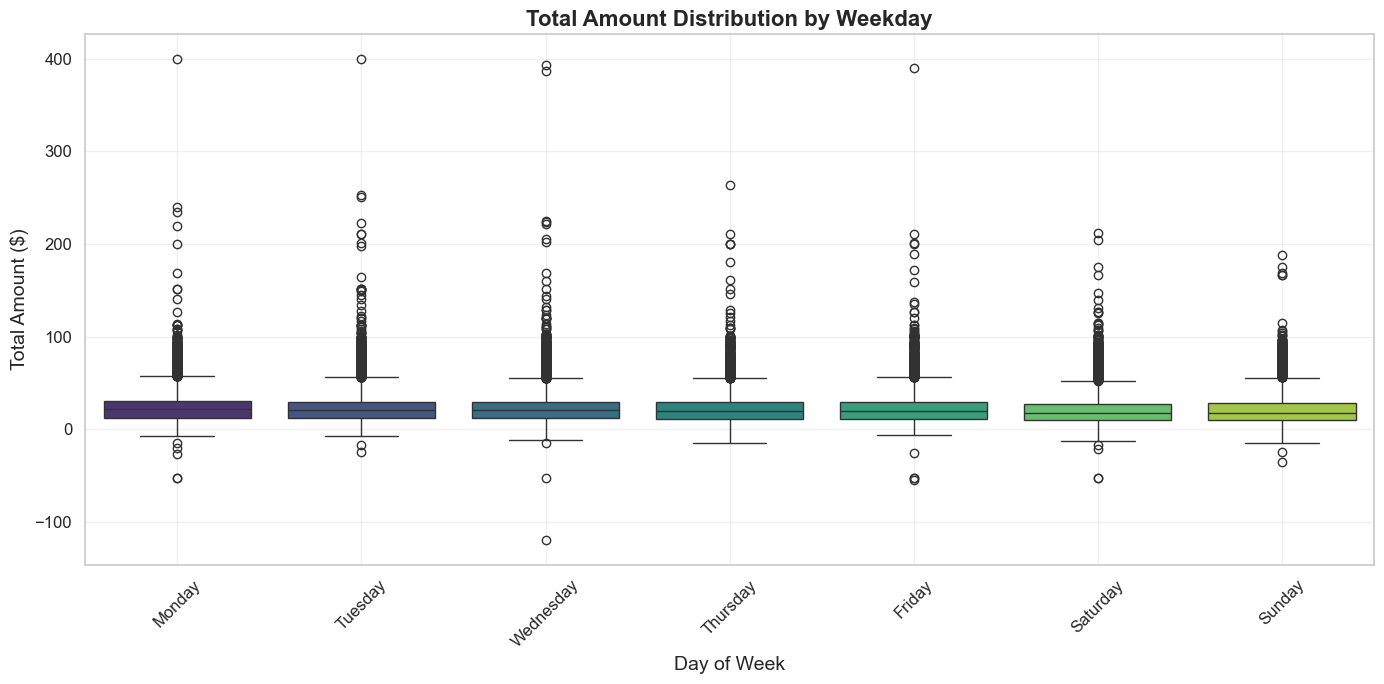


ANOVA Test for Total Amount across Weekdays:
F-statistic: 20.9844
p-value: 0.0000
Reject null hypothesis: Average total amounts are not identical across weekdays


In [50]:
# m) Test null average total_amount of different weekday is identical
# Visualize the data
plt.figure(figsize=(14, 7))
sns.boxplot(x='weekday', y='total_amount', data=df, order=weekday_order, palette=sns.color_palette('viridis', 7))
plt.title('Total Amount Distribution by Weekday', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Total Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('total_amount_by_weekday.png', dpi=300, bbox_inches='tight')
plt.show()

weekdays = df['weekday'].unique()
weekday_groups = [df[df['weekday'] == weekday]['total_amount'] for weekday in weekdays]

f_stat, p_value = stats.f_oneway(*weekday_groups)

print("\nANOVA Test for Total Amount across Weekdays:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: Average total amounts are not identical across weekdays")
else:
    print("Fail to reject null hypothesis: Average total amounts are identical across weekdays")

<Figure size 1200x700 with 0 Axes>

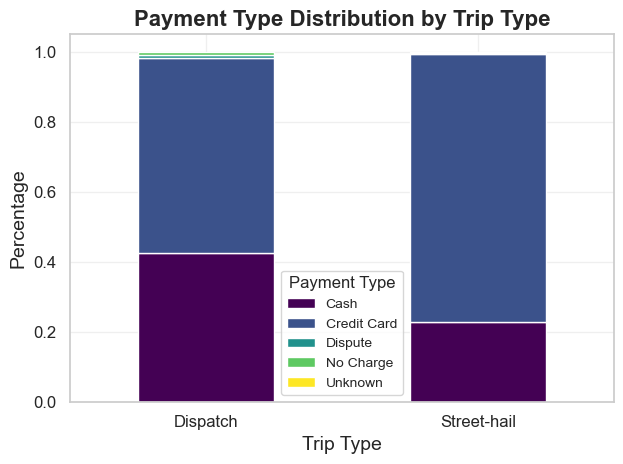


Chi-square Test for Association between Trip Type and Payment Type:
Chi-square statistic: 380.8771
p-value: 0.0000
Degrees of freedom: 4
Reject null hypothesis: There is an association between trip type and payment type


In [51]:
# n) Test null no association between trip_type and payment_type
if 'trip_type_desc' in df.columns:
    # Create a stacked bar chart
    plt.figure(figsize=(12, 7))
    crosstab = pd.crosstab(df['trip_type_desc'], df['payment_type_desc'])
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0)
    crosstab_pct.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Payment Type Distribution by Trip Type', fontsize=16, fontweight='bold')
    plt.xlabel('Trip Type', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Payment Type', title_fontsize=12, fontsize=10)
    plt.tight_layout()
    plt.savefig('payment_by_trip_type.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Chi-square test for independence
    contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print("\nChi-square Test for Association between Trip Type and Payment Type:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p < 0.05:
        print("Reject null hypothesis: There is an association between trip type and payment type")
    else:
        print("Fail to reject null hypothesis: No association between trip type and payment type")
else:
    print("\nTrip Type column does not exist. Cannot perform Chi-square test.")

In [52]:
# o & p) Identify numeric and object variables
numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
object_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove datetime columns and descriptive versions of categorical variables
numeric_vars = [col for col in numeric_vars if col not in ['payment_type_desc', 'trip_type_desc', 'ratecode_desc']]
object_vars = [col for col in object_vars if col not in ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'payment_type_desc', 'trip_type_desc', 'ratecode_desc']]

print("\nNumeric variables:")
print(numeric_vars)
print("\nObject variables:")
print(object_vars)


Numeric variables:
['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge', 'trip_duration']

Object variables:
['store_and_fwd_flag', 'weekday']


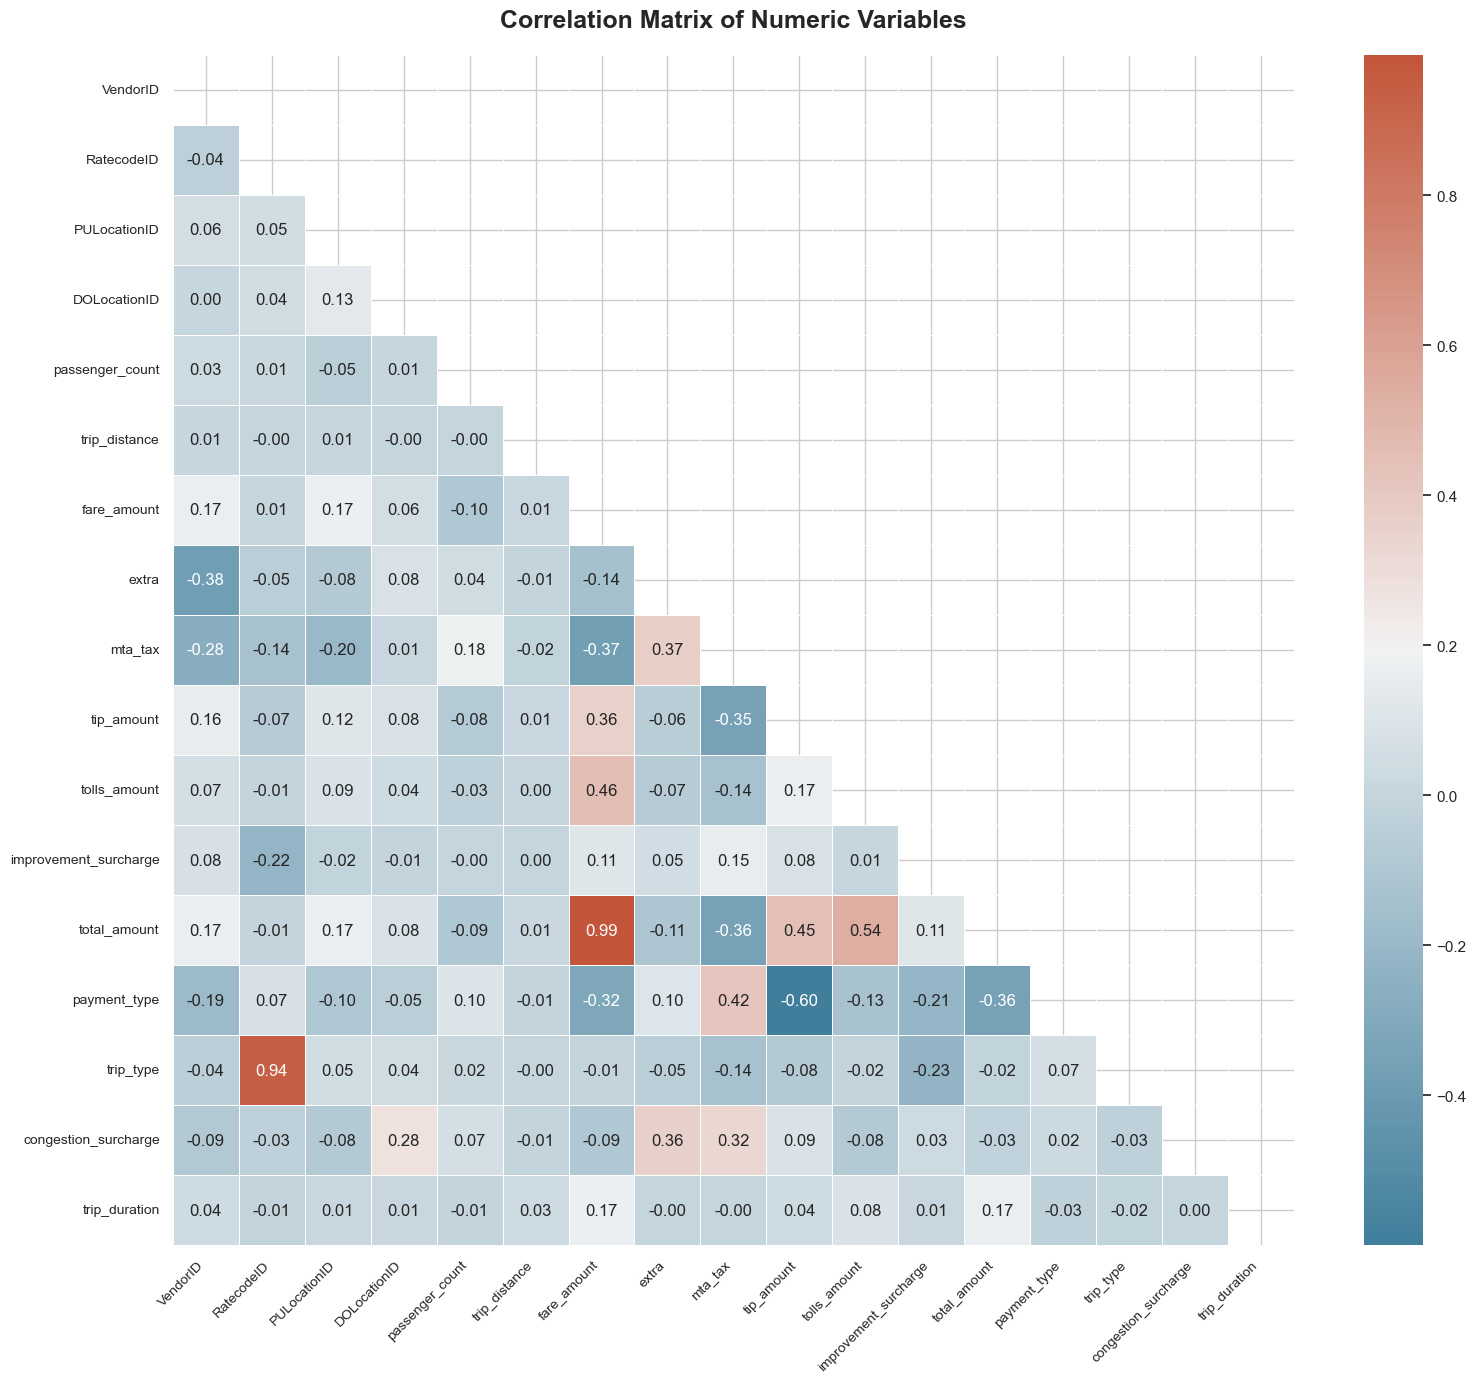

In [53]:
# q) Correlation analysis of numeric cols
plt.figure(figsize=(16, 14))
correlation_matrix = df[numeric_vars].corr()
mask = np.triu(correlation_matrix)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Numeric Variables', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# r) Dummy encode object cols
# First, ensure all object columns are converted to string type
for col in object_vars:
    if col in df.columns:
        df[col] = df[col].astype(str)

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=[col for col in object_vars if col in df.columns], drop_first=True)
print("\nShape after dummy encoding:", df_encoded.shape)


Shape after dummy encoding: (83130, 30)


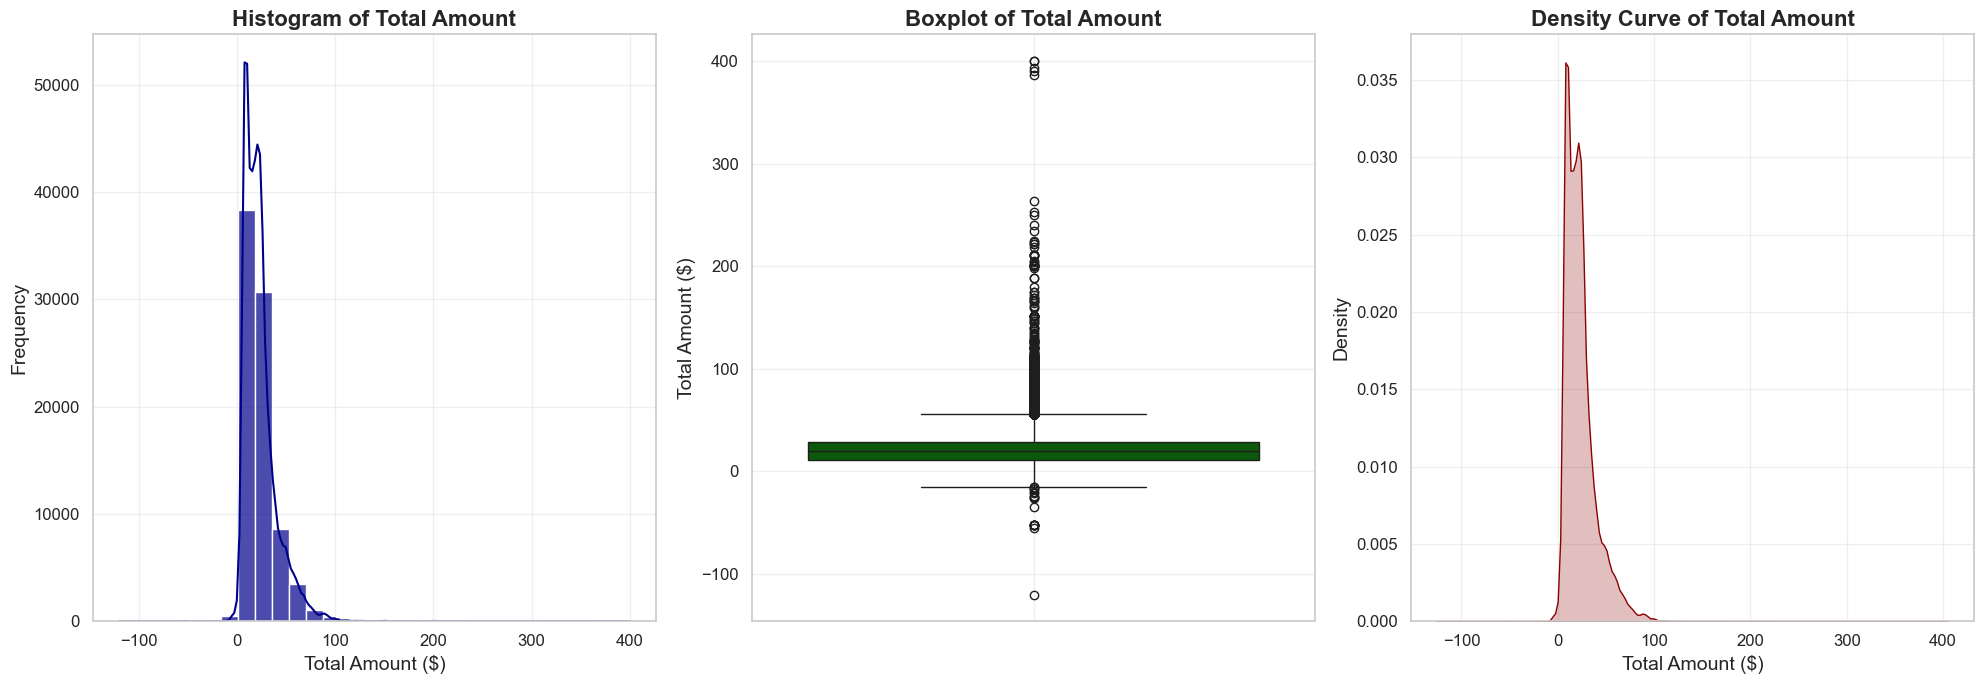

In [55]:
# s) Dependent Variable analysis: total_amount
plt.figure(figsize=(20, 7))

# Histogram with KDE
plt.subplot(1, 3, 1)
sns.histplot(df['total_amount'], kde=True, bins=30, color='darkblue', alpha=0.7)
plt.title('Histogram of Total Amount', fontsize=16, fontweight='bold')
plt.xlabel('Total Amount ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df['total_amount'], color='darkgreen')
plt.title('Boxplot of Total Amount', fontsize=16, fontweight='bold')
plt.ylabel('Total Amount ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.yticks(fontsize=12)

# Density Curve
plt.subplot(1, 3, 3)
sns.kdeplot(df['total_amount'], fill=True, color='darkred')
plt.title('Density Curve of Total Amount', fontsize=16, fontweight='bold')
plt.xlabel('Total Amount ($)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('total_amount_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Scaler saved to scaler.pkl

Linear_Regression Performance:
Train RMSE: 0.3176
Test RMSE: 0.3354
Train R²: 0.9996
Test R²: 0.9996
Test MAE: 0.1658
Model saved to linear_regression.pkl

Decision_Tree Performance:
Train RMSE: 0.0000
Test RMSE: 1.3710
Train R²: 1.0000
Test R²: 0.9935
Test MAE: 0.1270
Model saved to decision_tree.pkl

Random_Forest Performance:
Train RMSE: 0.3154
Test RMSE: 1.3355
Train R²: 0.9996
Test R²: 0.9938
Test MAE: 0.1085
Model saved to random_forest.pkl

Gradient_Boosting Performance:
Train RMSE: 0.4999
Test RMSE: 0.9650
Train R²: 0.9991
Test R²: 0.9968
Test MAE: 0.3475
Model saved to gradient_boosting.pkl


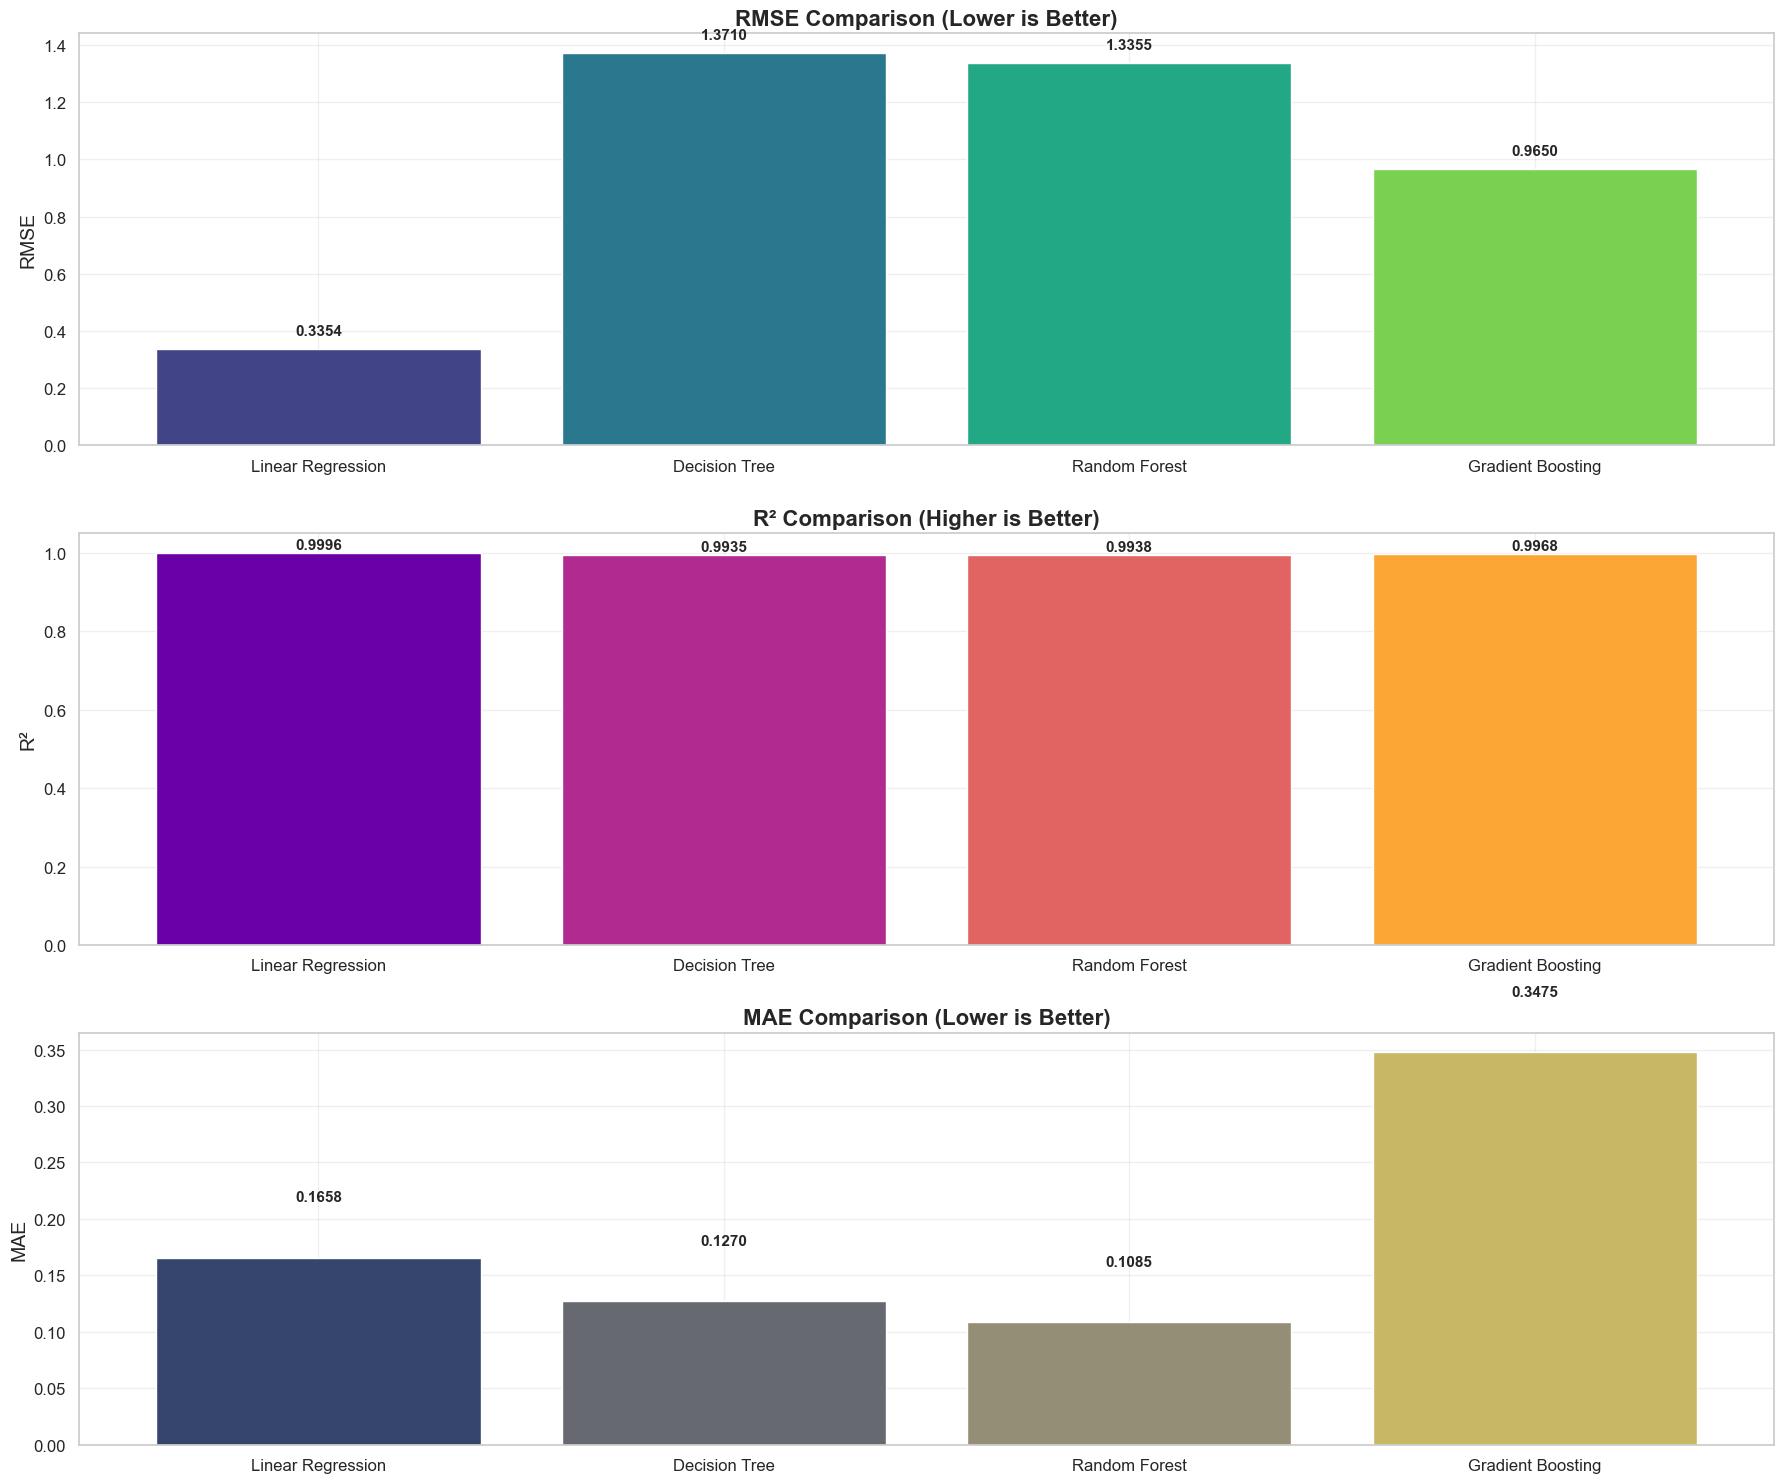

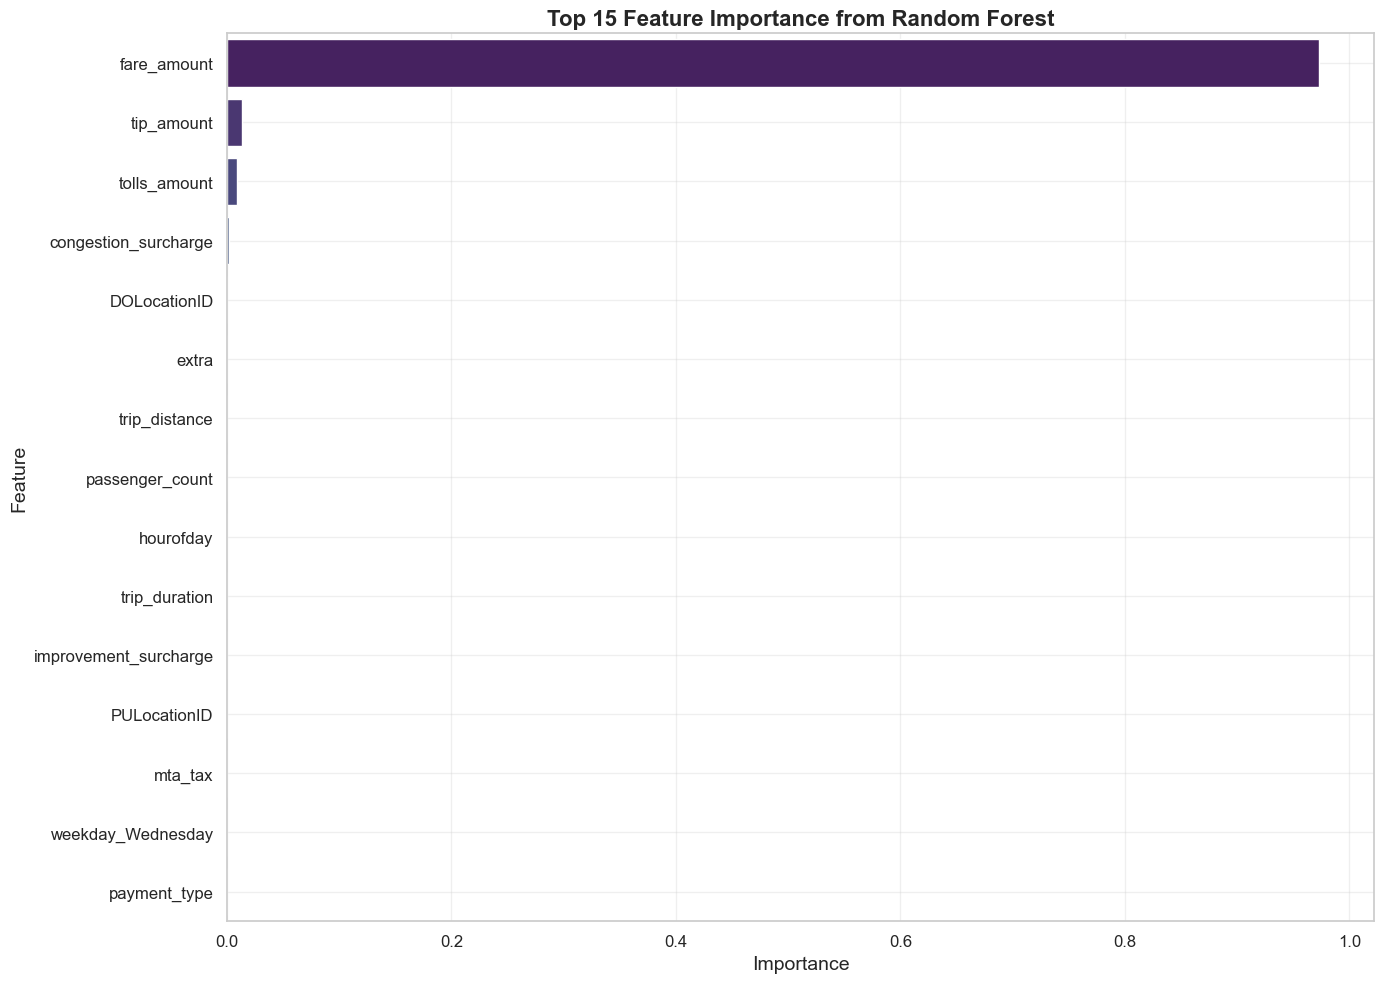

In [56]:
# t) Build Regression Models
# Prepare data for modeling
X = df_encoded.drop(['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'payment_type_desc', 'trip_type_desc', 'ratecode_desc'], axis=1, errors='ignore')
y = df_encoded['total_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
print("\nScaler saved to scaler.pkl")

# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, save_pkl=False):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Save the model if requested
    if save_pkl:
        model_file_name = f"{model_name.lower().replace(' ', '_')}.pkl"
        with open(model_file_name, 'wb') as model_file:
            pickle.dump(model, model_file)
        print(f"Model saved to {model_file_name}")
    
    return model, test_rmse, test_r2, test_mae

# Multiple Linear Regression
lr_model, lr_rmse, lr_r2, lr_mae = evaluate_model(
    LinearRegression(), 
    X_train_scaled, X_test_scaled, 
    y_train, y_test, 
    "Linear_Regression",
    save_pkl=True
)

# Decision Tree
dt_model, dt_rmse, dt_r2, dt_mae = evaluate_model(
    DecisionTreeRegressor(random_state=42), 
    X_train, X_test, 
    y_train, y_test, 
    "Decision_Tree",
    save_pkl=True
)

# Random Forest
rf_model, rf_rmse, rf_r2, rf_mae = evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42), 
    X_train, X_test, 
    y_train, y_test, 
    "Random_Forest",
    save_pkl=True
)

# Gradient Boosting
gb_model, gb_rmse, gb_r2, gb_mae = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, random_state=42), 
    X_train, X_test, 
    y_train, y_test, 
    "Gradient_Boosting",
    save_pkl=True
)

# Compare models
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
rmse_scores = [lr_rmse, dt_rmse, rf_rmse, gb_rmse]
r2_scores = [lr_r2, dt_r2, rf_r2, gb_r2]
mae_scores = [lr_mae, dt_mae, rf_mae, gb_mae]

plt.figure(figsize=(18, 15))

# RMSE comparison
plt.subplot(3, 1, 1)
bars = plt.bar(models, rmse_scores, color=sns.color_palette('viridis', len(models)))
plt.title('RMSE Comparison (Lower is Better)', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels
for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{score:.4f}', 
             ha='center', fontsize=11, fontweight='bold')

# R² comparison
plt.subplot(3, 1, 2)
bars = plt.bar(models, r2_scores, color=sns.color_palette('plasma', len(models)))
plt.title('R² Comparison (Higher is Better)', fontsize=16, fontweight='bold')
plt.ylabel('R²', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels
for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', 
             ha='center', fontsize=11, fontweight='bold')

# MAE comparison
plt.subplot(3, 1, 3)
bars = plt.bar(models, mae_scores, color=sns.color_palette('cividis', len(models)))
plt.title('MAE Comparison (Lower is Better)', fontsize=16, fontweight='bold')
plt.ylabel('MAE', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels
for bar, score in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{score:.4f}', 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance from Random Forest
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_features = feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 15 Feature Importance from Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()